Gather the mean values of T2 from every BA in the Historical dataset and create a time series analysis

In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

In [2]:
def t2_mean(path):
    
    # input the directory to the set of files as a raw string e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT'
    files_path = path
    list_of_files = glob.glob(os.path.join(files_path , "*.csv"))
    
    # create a list of the mean of T2 of each file
    means_list = []
    for file_name in list_of_files:
        df = pd.read_csv(file_name, index_col = None, header = 0)
        means_list.append(df['T2'].mean())
    
    means_df = pd.DataFrame(means_list, columns = ["T2_Mean"])
    
    # create list of file names to get more information for each T2
    files = []
    for file_path in list_of_files:
        name = os.path.basename(file_path)
        files.append(name)
     
    # split the file names into lists in BA_list
    BA_list_split = []
    for csv_name in range(len(files)):
        base_name = os.path.splitext(os.path.basename(files[csv_name]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)
        
    # take the first elements (BAs) and last elements (years) and put them into their respective lists
    BA_names = []
    years = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        years.append(file_list[5])
        
    # add BA and Year columns to dataframe and correct the column order
    means_df['BA'] = BA_names
    means_df['Year'] = years

    means_df = means_df[['BA', 'Year', 'T2_Mean']]
    
    return means_df

In [3]:
# create a df for both the cold and hot datasets using t2_mean function
hot_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')
cold_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD')

In [4]:
def t2_visual(input_BA): # insert a BA as a string e.g. 'AEC'
    
    # need to take the BA string input, and create subsets of hot_df and cold_df from them
    cold_BA = cold_df.loc[(cold_df['BA'] == input_BA)]
    hot_BA = hot_df.loc[(hot_df['BA'] == input_BA)]
    
    # create and show the visualization
    plt.plot(hot_BA['Year'], hot_BA['T2_Mean'], color = "red", label = "Hot")
    plt.plot(cold_BA['Year'], cold_BA['T2_Mean'], color = "blue", label = "Cold")
    
    plt.legend(loc="upper left")
    plt.xlabel('Year')
    plt.title('A Comparison of ' + input_BA + ' Scenarios')
    plt.ylabel('T2_Mean (K)')

    plt.xticks([0, 20, 40, 60, 79])
    
    plt.show()
    
    # express the temperature differences at initial and final points
    temp_diff_df = hot_BA['T2_Mean'] - cold_BA['T2_Mean']
    
    temp_diff_li = list(temp_diff_df)

    # use for loop to print where difference becomes "significant" e.g. 1 dg
    initial_temp_diff = temp_diff_df.iloc[0].round(2)
    final_temp_diff = temp_diff_df.iloc[-1].round(2)
    
    print('2020 temperature difference: ' + str(initial_temp_diff))
    print('2099 temperature difference: ' + str(final_temp_diff))
    
    # add plot legend plt.legend()
    
    # add units (kelvin) maybe convert to F
    
    return

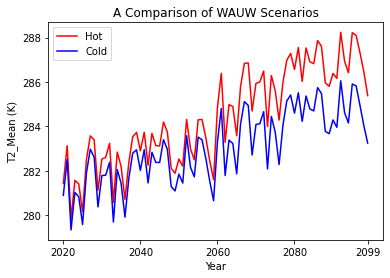

2020 temperature difference: 0.54
2099 temperature difference: 2.14


In [5]:
t2_visual('WAUW')

New function to loop through the BAs and find first year where difference is greater than 1dg (or use as another input variable in function). Plot this. Use unique values in hot_df and cold_df to get list of BAs. calculate pdf (using python package) of temp for a given decade/5yr span (using a loop to separate data by decade), see if approximates to normal.

In [6]:
hot_df

,BA,Year,T2_Mean
0,AECI,2020,288.445799
1,AECI,2021,288.530342
2,AECI,2022,287.674314
3,AECI,2023,287.652112
4,AECI,2024,287.897982
...,...,...,...
4555,WAUW,2095,288.223081
4556,WAUW,2096,288.100712
4557,WAUW,2097,287.319889
4558,WAUW,2098,286.457986


In [7]:
def temp_diff_years(input_temp): # input BA as string e.g. 'AEC'. input temp as float/integer.
      
    # get list of unique BAs
    BA_unique = hot_df.BA.unique()
    BA_list = list(BA_unique)
    
    # subset hot/cold data for each BA
    temp_gap_years = []
    for BA_name in BA_list:
        cold_BA = cold_df.loc[(cold_df['BA'] == BA_name)]
        hot_BA = hot_df.loc[(hot_df['BA'] == BA_name)]
        
        # within subset, find temp difference > input temp
        temp_diff_df = hot_BA['T2_Mean'] - cold_BA['T2_Mean']
        temp_diff_li = list(temp_diff_df)
        year_li = list(range(2020, 2099))
    
        for temp_diff in temp_diff_li:
            if temp_diff > input_temp:
                temp_index = temp_diff_li.index(temp_diff)
                break
                
        # take that temp_index, and append to list of temp_gap_years, which is the year the difference between hot and cold first exceeded input_temp
        first_year = year_li[temp_index]
        temp_gap_years.append(first_year)

    return temp_gap_years

Text(0.5, 1.0, 'Years where Cold and Hot first diverge by 1dg K')

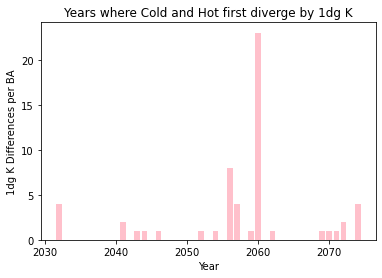

In [34]:
# use temp_diff_years function to get years where difference begins to get larger than 1 dg
one_dg = temp_diff_years(1)

# sort years by ascending order to get better graph
one_dg.sort()

# create dictionary to count number of times each year appears in one_dg
one_dg_dict = {i:one_dg.count(i) for i in one_dg}
one_dg_dict

# plot a bar graph
years = list(one_dg_dict.keys())
one_dg_counts = list(one_dg_dict.values())

plt.bar(years, one_dg_counts, color = 'pink')
plt.xlabel('Year')
plt.ylabel('1dg K Differences per BA')
plt.title('Years where Cold and Hot first diverge by 1dg K')